In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import collections
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
import warnings
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score

## Cleaning Data

In [3]:
df_income = pd.read_csv('adult.csv')
df_income.head(2)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K


In [4]:
df_income[df_income == '?'] = np.nan
df_income['income >50k?'] = df_income['income'].map(lambda i: 1 if i == '>50K' else 0)

for col in ['workclass', 'occupation', 'native.country']:
    df_income[col].fillna(value=df_income[col].mode()[0], inplace=True)
    
df_income.head(2)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,income >50k?
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,0


In [5]:
data = df_income.drop(['income', 'income >50k?'], axis=1)
labels = df_income['income']

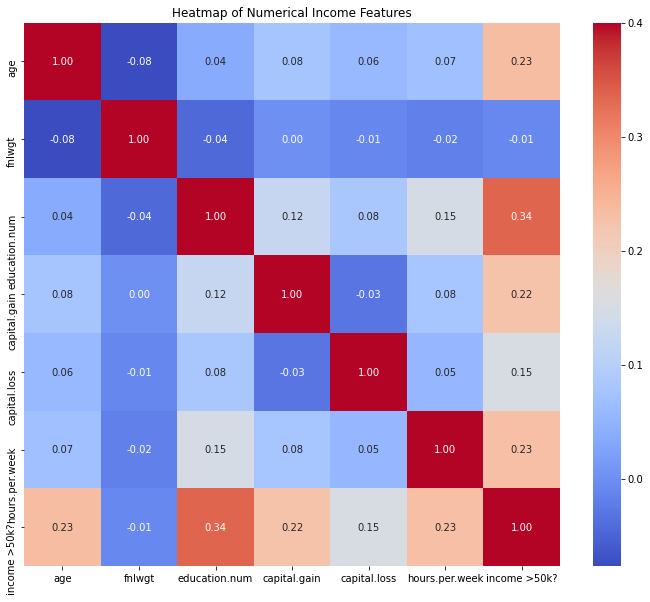

In [6]:
plt.figure(figsize=(12, 10))
corr = df_income.select_dtypes(include=['int64', 'float64']).corr()
plt.title('Heatmap of Numerical Income Features')
sns.heatmap(corr, vmax=.4, annot=True, fmt='.2f', cmap='coolwarm');

## Random Forest, Decision Tree, and K-NN Classifier Performance

In [7]:
# return cross-validated predictions for a given classifier
def cross_val_classify(x, y, clf, n_splits=10):
    kfold = StratifiedKFold(n_splits=10)
    y_pred = np.empty_like(y)

    for train_idx, test_idx in kfold.split(x, y):
        x_train = x[train_idx, :]
        y_train = y[train_idx]
        x_test = x[test_idx, :]

        clf.fit(x_train, y_train)
        y_pred[test_idx] = clf.predict(x_test)
    
    return y_pred

In [8]:
# plot confusion matrix between predicted results and actual results
def conf_mat_plot(y_true, y_pred, clf_name):
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
    sns.reset_orig()
    conf_mat_disp.plot()

    plt.gcf().set_size_inches(5, 4)
    plt.title(f'10-fold Cross Validated {clf_name}')
    plt.xlabel('Predicted Income Bracket')
    plt.ylabel('True Income Bracket')
    
    accuracy = np.diag(conf_mat).sum() / conf_mat.sum()
    print(f'{clf_name} accuracy = {(accuracy * 100):.3f}%')

In [9]:
# histogram plot the results between predicted and actual values
def pred_vs_actual_plot(y_true, y_pred, clf_name):
    plt.figure(figsize=(8, 6))
    plt.hist([y_true, y_pred], label=['Actual Values', 'Predicted Values'])
    plt.legend()
    plt.title(f'Predicted vs. Actual Values for {clf_name}')
    plt.xlabel('Income Bracket (Exceed 50K?)')
    plt.ylabel('Count')
    plt.show()

Random Forest Classifier accuracy = 76.721%


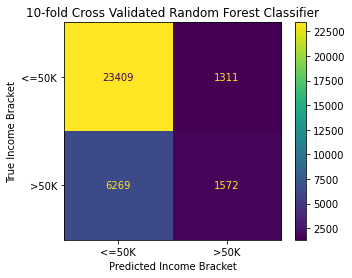

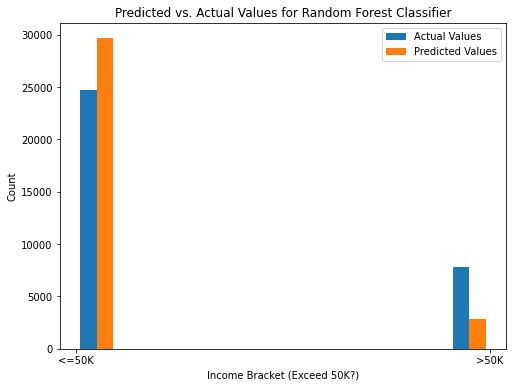

Decision Tree Classifier accuracy = 75.520%


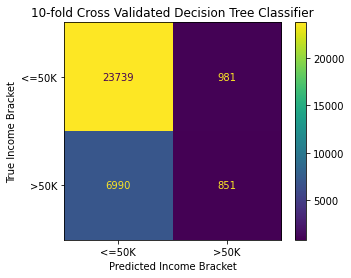

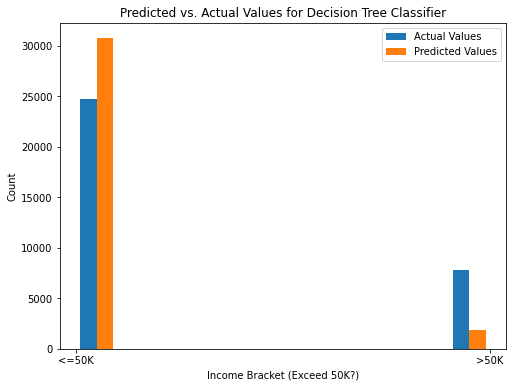

KNN Classifier accuracy = 73.871%


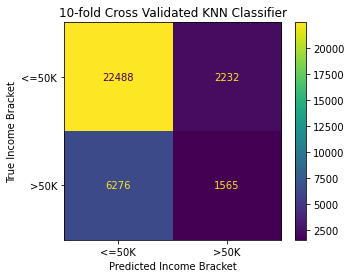

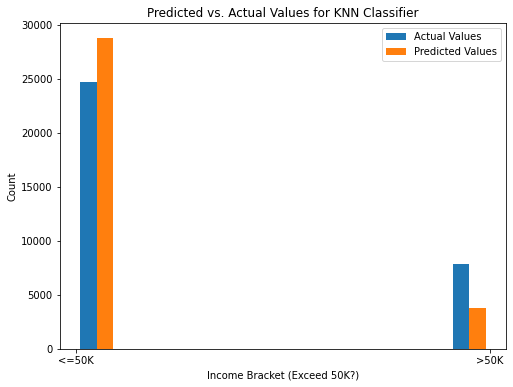

In [10]:
# initialize x features and y (target) values, classifiers
x_features = data.select_dtypes(include=['int64', 'float64']).columns
x = df_income.loc[:, x_features].values
y = df_income.loc[:, 'income'].values

classifiers = \
{
    'Random Forest Classifier': RandomForestClassifier(max_depth=4),
    'Decision Tree Classifier': DecisionTreeClassifier(max_depth=4),
    'KNN Classifier': KNeighborsClassifier(n_neighbors=5)
}

# iterate through each classifier to print confusion matrix and histogram of performance
for clf_name, clf in classifiers.items():
    y_test_pred = cross_val_classify(x, y, clf)
    conf_mat_plot(y, y_test_pred, clf_name)
    pred_vs_actual_plot(y, y_test_pred, clf_name)

## Testing Feature Importance w/o Using K-Fold Cross Validation

In [11]:
# split data into test/training
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.3, random_state = 0)
categorical_variables = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
for feature in categorical_variables:
        label_encoder = preprocessing.LabelEncoder()
        train_data.loc[:, feature] = label_encoder.fit_transform(train_data.loc[:, feature])
        test_data.loc[:, feature] = label_encoder.transform(test_data.loc[:, feature])

# map classifiers to their name
classifiers = {
    'Random Forest Classifier': RandomForestClassifier(max_depth=3),
    'Decision Tree Classifier': DecisionTreeClassifier(max_depth=3),
}

# plot feature importance for a given classifier
def feature_importance_plot(clf, clf_name, X_train):
    importances = clf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    plt.title(f"Feature Importance using {clf_name}")
    plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
    plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
# plot accuracy table for a classifier
def show_accuracies(train_pred, test_pred, clf_name):
    train_acc = np.around(sum(train_pred == train_labels)/len(train_labels) * 100, decimals=3)
    test_acc = np.around(sum(test_pred == test_labels)/len(test_labels) * 100, decimals=3)
    
    fig, ax = plt.subplots()
    ax.set_title(f"Testing Accuracy of {clf_name} on Our Data")
    table_data=[
        ["Accuracy for Training Data", f"{train_acc}%"],
        ["Accuracy for Testing Data", f"{test_acc}%"]
    ]
    table = ax.table(cellText=table_data, loc='center')
    table.set_fontsize(12)
    table.scale(1,4)
    ax.axis('off')
    plt.show()

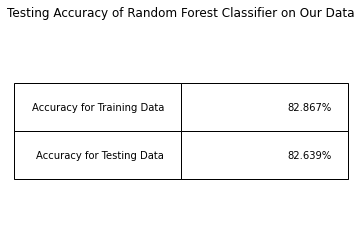

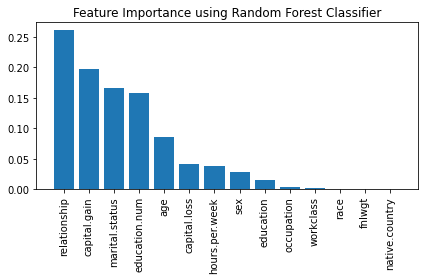

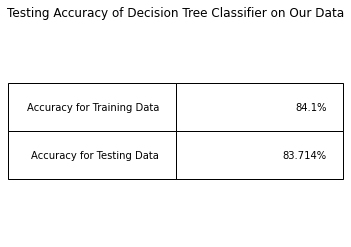

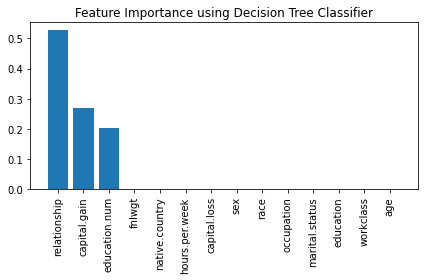

In [12]:
# iterate through classifiers to show each feature importance and accuracy
for clf_name, clf in classifiers.items():
    clf.fit(train_data,train_labels)
    train_pred = clf.predict(train_data)
    test_pred = clf.predict(test_data)
    show_accuracies(train_pred, test_pred, clf_name)
    feature_importance_plot(clf, clf_name, train_data)